## Import Libraries and Functions

In [6]:
import pandas as pd
import numpy as np
import requests
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'jupyterlab'
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import chart_studio.plotly as py
import plotly.graph_objects as go
from tensorflow.python.keras.saving.hdf5_format import save_attributes_to_hdf5_group
import keras
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [7]:
def chapter_split(text):
    reference_list = text.split(' ')
    chapter_verse = reference_list[-1].split(':')
    return int(chapter_verse[0])

In [8]:
def sentiment_score_weight(sentiment):
    label = sentiment['label']
    # print(label)
    score = float(sentiment['score'])
    # print(score)
    label_value = 1 if label == 'POSITIVE' else -1
    weighted_score = label_value*score
    return weighted_score

In [9]:
def book_split(text):
    book = text.split(' ')
    return ' '.join(book[0:len(book)-1])

In [10]:
def printable_string(text):
    # string.translate(text, string.printable)
    # text = text.translate(str.maketrans('', '', string.printable))
    # filtered_string = (filter(lambda x: x in string.printable, text))
    filtered_string = ''.join(s for s in text if s in string.printable)
    return filtered_string

In [11]:
BOOKS_OLD_TESTAMENT = [
'Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy', 'Joshua', 'Judges', 'Ruth',
'1 Samuel', '2 Samuel', '1 Kings', '2 Kings', '1 Chronicles', '2 Chronicles', 'Ezra', 'Nehemiah',
'Esther', 'Job', 'Psalms', 'Proverbs', 'Ecclesiastes', 'Song of Solomon', 'Isaiah', 'Jeremiah',
'Lamentations', 'Ezekiel', 'Daniel', 'Hosea', 'Joel', 'Amos', 'Obadiah', 'Jonah',
'Micah', 'Nahum', 'Habakkuk', 'Zephaniah', 'Haggai', 'Zechariah', 'Malachi'
]
BOOKS_NEW_TESTAMENT = [
'Matthew', 'Mark', 'Luke', 'John', 'Acts', 'Romans', '1 Corinthians', '2 Corinthians',
'Galatians', 'Ephesians', 'Philippians', 'Colossians', '1 Thessalonians', '2 Thessalonians', '1 Timothy', '2 Timothy',
'Titus', 'Philemon', 'Hebrews', 'James', '1 Peter', '2 Peter', '1 John', '2 John',
'3 John', 'Jude', 'Revelation'
]

### Data Extraction

In [12]:
bible_url = 'https://bereanbible.com/bsb.txt'

In [13]:
with open('./data/bereanbible.txt', 'r') as f:
    text = f.read()

In [14]:
response = requests.get(bible_url)
raw_bible = response.text

In [15]:
bible_list = raw_bible.splitlines()

In [16]:
bible_array = np.array([item.split('\t') for item in bible_list])

In [17]:
bible_array[:, 1] = np.array([printable_string(verse) for verse in bible_array[:, 1]])

In [18]:
bible_array.shape

(31105, 2)

In [19]:
df = pd.DataFrame(bible_array[3:, :], columns=['reference','text'])

### Data Cleanup

In [20]:
df['chapter'] = df['reference'].apply(chapter_split)

In [21]:
df['book'] = df['reference'].apply(book_split)
df['testament'] = df['book'].apply(lambda x: 'OT' if x in BOOKS_OLD_TESTAMENT else 'NT')

In [22]:
df.head()

,reference,text,chapter,book,testament
0,Genesis 1:1,In the beginning God created the heavens and t...,1,Genesis,OT
1,Genesis 1:2,"Now the earth was formless and void, and darkn...",1,Genesis,OT
2,Genesis 1:3,"And God said, Let there be light, and there wa...",1,Genesis,OT
3,Genesis 1:4,"And God saw that the light was good, and He se...",1,Genesis,OT
4,Genesis 1:5,"God called the light day, and the darkness He ...",1,Genesis,OT


## Refine Analysis with Gospel NLP using LLMs

### Create Gospels dataframe

In [23]:
gospels_list = ['Matthew', 'Mark', 'Luke', 'John']
df_gospels = df.copy()
df_gospels = df_gospels[df_gospels['book'].isin(gospels_list)]
df_gospels['chapter'] = df_gospels['reference'].apply(chapter_split)

In [24]:
sentiment_pipeline = pipeline("sentiment-analysis")
text = list(df_gospels['text'])
gospels_output = sentiment_pipeline(text)
df_gospels['sentiment'] = gospels_output
df_gospels['weighted_score'] = df_gospels['sentiment'].apply(lambda x: sentiment_score_weight(sentiment=x))
df_gospels.head()

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


,reference,text,chapter,book,testament,sentiment,weighted_score
23145,Matthew 1:1,This is the record of the genealogy of Jesus C...,1,Matthew,NT,"{'label': 'POSITIVE', 'score': 0.9846351742744...",0.984635
23146,Matthew 1:2,"Abraham was the father of Isaac, Isaac the fat...",1,Matthew,NT,"{'label': 'POSITIVE', 'score': 0.9951820969581...",0.995182
23147,Matthew 1:3,Judah was the father of Perez and Zerah by Tam...,1,Matthew,NT,"{'label': 'POSITIVE', 'score': 0.9947454929351...",0.994745
23148,Matthew 1:4,"Ram was the father of Amminadab, Amminadab the...",1,Matthew,NT,"{'label': 'POSITIVE', 'score': 0.9743419885635...",0.974342
23149,Matthew 1:5,"Salmon was the father of Boaz by Rahab, Boaz t...",1,Matthew,NT,"{'label': 'POSITIVE', 'score': 0.9916356801986...",0.991636


### Aggregate by chapter

In [25]:
df_gospels_chapters = df_gospels[['book', 'chapter', 'weighted_score']].groupby(['book','chapter']).mean()
df_gospels_chapters = df_gospels_chapters.reset_index()
df_gospels_chapters.head()

,book,chapter,weighted_score
0,John,1,0.160530
1,John,2,-0.084094
2,John,3,0.206644
3,John,4,0.005583
4,John,5,0.064312


### Visualize chapter aggregations

<AxesSubplot: xlabel='chapter', ylabel='weighted_score'>

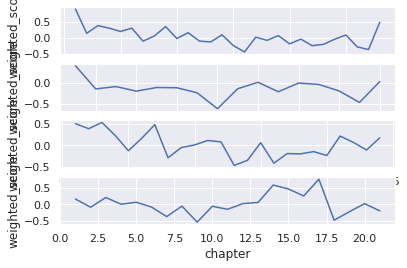

In [26]:
# set seaborn plotting aesthetics as default
sns.set()

fig, axes = plt.subplots(4, 1, sharey=False)

#create boxplot in each subplot
sns.lineplot(data=df_gospels_chapters[df_gospels_chapters['book'] == 'Matthew']
             , x='chapter', y='weighted_score', ax=axes[0])
sns.lineplot(data=df_gospels_chapters[df_gospels_chapters['book'] == 'Mark']
             , x='chapter', y='weighted_score', ax=axes[1])
sns.lineplot(data=df_gospels_chapters[df_gospels_chapters['book'] == 'Luke']
             , x='chapter', y='weighted_score', ax=axes[2])
sns.lineplot(data=df_gospels_chapters[df_gospels_chapters['book'] == 'John']
             , x='chapter', y='weighted_score', ax=axes[3])

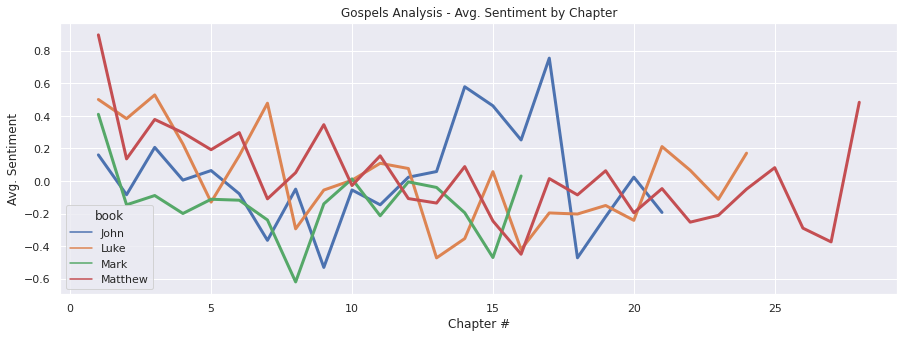

In [63]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(ax=ax, data=df_gospels_chapters, hue='book', linewidth=3, x='chapter', y='weighted_score')
plt.xlabel("Chapter #")
plt.ylabel("Avg. Sentiment")
plt.title("Gospels Analysis - Avg. Sentiment by Chapter")
plt.show(fig)

### Aggregate by using a moving average

In [30]:
df_gospels.groupby('book')['weighted_score'].transform(lambda x: x.rolling(10, 1).mean())

23145    0.984635
23146    0.989909
23147    0.991521
23148    0.987226
23149    0.988108
           ...   
26919   -0.163843
26920    0.006807
26921   -0.174596
26922    0.019670
26923   -0.178974
Name: weighted_score, Length: 3779, dtype: float64

In [59]:
df_gospels_rolling = df_gospels.groupby('book').rolling(40)['weighted_score'].mean().reset_index()
df_gospels_rolling = df_gospels_rolling.dropna()
df_gospels_rolling['counter'] = df_gospels_rolling.groupby(['book']).cumcount()

In [60]:
df_gospels_rolling.head()

,book,level_1,weighted_score,counter
39,John,26084,0.068518,0
40,John,26085,0.067229,1
41,John,26086,0.067573,2
42,John,26087,0.114935,3
43,John,26088,0.073692,4


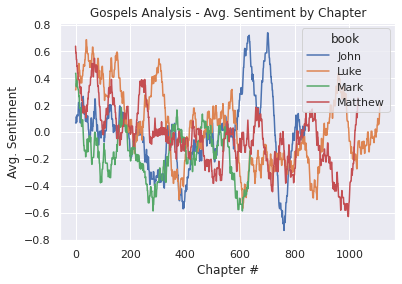

In [61]:
fig = sns.lineplot(data=df_gospels_rolling, hue='book', x='counter', y='weighted_score')
plt.xlabel("Chapter #")
plt.ylabel("Avg. Sentiment")
plt.title("Gospels Analysis - Avg. Sentiment by Chapter")
plt.show(fig)

In [ ]:
# set seaborn plotting aesthetics as default
sns.set()

fig, axes = plt.subplots(4, 1, sharey=False)

#create boxplot in each subplot
sns.lineplot(data=df_gospels_chapters[df_gospels_chapters['book'] == 'Matthew']
             , x='chapter', y='weighted_score', ax=axes[0])
sns.lineplot(data=df_gospels_chapters[df_gospels_chapters['book'] == 'Mark']
             , x='chapter', y='weighted_score', ax=axes[1])
sns.lineplot(data=df_gospels_chapters[df_gospels_chapters['book'] == 'Luke']
             , x='chapter', y='weighted_score', ax=axes[2])
sns.lineplot(data=df_gospels_chapters[df_gospels_chapters['book'] == 'John']
             , x='chapter', y='weighted_score', ax=axes[3])